# Exploring the Overcooked MDP and Environment

_In this notebook we will:_
1. Load and inspect the Overcooked MDP.  
2. Wrap it in the RL-friendly `OvercookedEnv`.  
3. Discover how to extract the underlying grid layout.  
4. Visualize states with the provided `StateVisualizer`.  
5. Step through a couple of actions and render the results.  

---

In [17]:
# Cell 1: Imports
import copy
import math
import os

# Core MDP, actions, planners
from overcooked_ai_py.mdp.overcooked_mdp import OvercookedGridworld
from overcooked_ai_py.mdp.actions import Action
from overcooked_ai_py.planning.planners import MediumLevelActionManager, NO_COUNTERS_PARAMS

# RL wrapper
from overcooked_ai_py.mdp.overcooked_env import OvercookedEnv

# Visualization
from overcooked_ai_py.visualization.state_visualizer import StateVisualizer

---

## 2. Instantiate the MDP and Environment

We’ll pick the “asymmetric_advantages” layout and a horizon of 400 timesteps.


In [18]:
# Cell 2: Build MDP & Env
mdp = OvercookedGridworld.from_layout_name("asymmetric_advantages")
env = OvercookedEnv.from_mdp(mdp, horizon=400)

# Standard start state
state0 = mdp.get_standard_start_state()

---

## 3. Visualize the Initial State

`StateVisualizer` needs the raw layout grid.  Unfortunately the MDP doesn’t expose it as `.terrain`, but either as `.terrain_mtx` or `.grid`.  We can fall back gracefully.


In [20]:
# Cell 3: Extract the layout grid
try:
    grid = mdp.terrain_mtx
except AttributeError:
    grid = mdp.grid

print(f"Grid size: {len(grid)}×{len(grid[0])}")
grid  # display the 2D list of chars


Grid size: 5×9


[['X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X'],
 ['O', ' ', 'X', 'S', 'X', 'O', 'X', ' ', 'S'],
 ['X', ' ', ' ', ' ', 'P', ' ', ' ', ' ', 'X'],
 ['X', ' ', ' ', ' ', 'P', ' ', ' ', ' ', 'X'],
 ['X', 'X', 'X', 'D', 'X', 'D', 'X', 'X', 'X']]

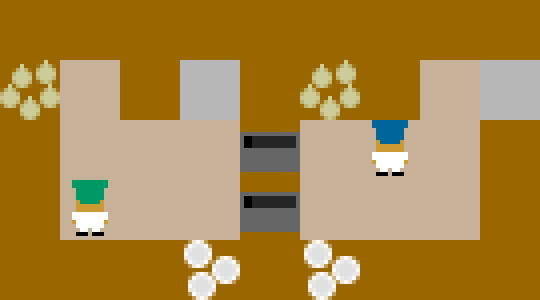

'/var/folders/x9/scyyg02s20v0759sw_qxdlqc0000gn/T/overcooked_visualized_state_4babe114-21c8-11f0-b0fc-665cc768392c.png'

In [21]:
# Cell 4: Render initial state inline
viz = StateVisualizer(tile_size=60, is_rendering_action_probs=False)
viz.display_rendered_state(state0, grid=grid, ipython_display=True)

---

## 4. Single‐Step Transition

Let’s apply both agents choosing `INTERACT` at t=0, then visualize the result.


Logged events: {'tomato_pickup': [False, False], 'useful_tomato_pickup': [False, False], 'tomato_drop': [False, False], 'useful_tomato_drop': [False, False], 'potting_tomato': [False, False], 'onion_pickup': [False, False], 'useful_onion_pickup': [False, False], 'onion_drop': [False, False], 'useful_onion_drop': [False, False], 'potting_onion': [False, False], 'dish_pickup': [False, False], 'useful_dish_pickup': [False, False], 'dish_drop': [False, False], 'useful_dish_drop': [False, False], 'soup_pickup': [False, False], 'soup_delivery': [False, False], 'soup_drop': [False, False], 'optimal_onion_potting': [False, False], 'optimal_tomato_potting': [False, False], 'viable_onion_potting': [False, False], 'viable_tomato_potting': [False, False], 'catastrophic_onion_potting': [False, False], 'catastrophic_tomato_potting': [False, False], 'useless_onion_potting': [False, False], 'useless_tomato_potting': [False, False]}


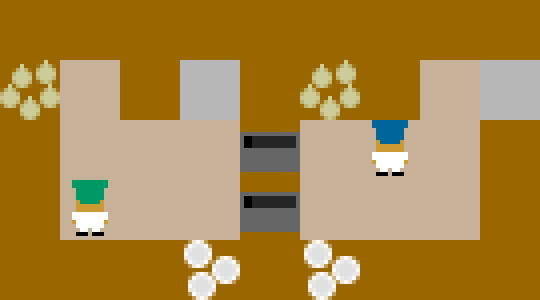

'/var/folders/x9/scyyg02s20v0759sw_qxdlqc0000gn/T/overcooked_visualized_state_5affef5c-21c8-11f0-b0fc-665cc768392c.png'

In [22]:
# Cell 5: Step the MDP directly
joint_action = (Action.INTERACT, Action.INTERACT)
next_state, info = mdp.get_state_transition(state0, joint_action)
print("Logged events:", info['event_infos'])

# Visualize
viz.display_rendered_state(next_state, grid=grid, ipython_display=True)

---

## 5. Featurizations

### 5.1 Lossless Mask Encoding

A stack of boolean masks, one channel per terrain/agent/object layer.


In [23]:
# Cell 6: Lossless encoding
mask_p0, mask_p1 = mdp.lossless_state_encoding(state0)
print("Mask shape per player:", mask_p0.shape)


Mask shape per player: (9, 5, 26)


### 5.2 Hand-Crafted Feature Vector

Distances, counts, relative positions, etc., for CNN-free RL agents.


In [24]:
# Cell 7: Hand-crafted encoding (requires planner)
mlam = MediumLevelActionManager.from_pickle_or_compute(mdp, NO_COUNTERS_PARAMS)
features = mdp.featurize_state(state0, mlam, num_pots=2)
print("Feature vector length per player:", features[0].shape[0])


Feature vector length per player: 96


---

## 6. Potential Function for Reward Shaping

A heuristic estimate of future return under greedy planning.


In [25]:
# Cell 8: Compute potential
phi = mdp.potential_function(state0, mlam.motion_planner, gamma=0.99)
print("State potential:", phi)


State potential: 30.633689117862914


---

## 7. Rolling Out a Trajectory

We can use `OvercookedEnv.get_rollouts` to simulate a pair of random agents and visualize.


In [26]:
# Cell 9: Generate and visualize one rollout
from overcooked_ai_py.agents.agent import AgentPair, RandomAgent

agent_pair = AgentPair(RandomAgent(all_actions=True), RandomAgent(all_actions=True))
traj = env.get_rollouts(agent_pair, num_games=1, display=False, info=True)

# Render trajectory inline
viz.display_rendered_trajectory(traj, trajectory_idx=0, ipython_display=True)


Avg rew: 0.00 (std: 0.00, se: 0.00); avg len: 400.00; : 100%|██████████| 1/1 [00:00<00:00, 15.64it/s]


Computing MotionPlanner
Computing MotionPlanner to be saved in /Users/eirikvarnes/code/overcooked-rl-project/overcooked_ai/src/overcooked_ai_py/data/planners/asymmetric_advantages_mp.pkl
It took 0.03780508041381836 seconds to create mp


interactive(children=(IntSlider(value=0, description='timestep', max=399), Output()), _dom_classes=('widget-in…

---

## Summary

In this notebook we have:

- **Built** the core `OvercookedGridworld` MDP  
- **Wrapped** it in `OvercookedEnv` for standard `reset/step` RL usage  
- **Visualized** raw states and transitions with `StateVisualizer`  
- **Extracted** both mask stacks and hand-crafted feature vectors  
- **Computed** a potential shaping function  
- **Simulated** complete rollouts  

You can now hook in your favorite RL algorithm—using the featurizations or raw mask inputs—to train agents to collaborate in Overcooked.
